In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from datetime import timedelta, datetime

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

from utils import dt2int
from IPython.display import clear_output

In [2]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"
START_TIME = datetime.now()

# better plots
sns.set()

# tqdm
tqdm.pandas()

In [3]:
# Create a simulation environment
patient = T1DPatient.withName("adult#001") #.withParams(custom_params)
sensor = CGMSensor.withName("Dexcom", seed=GLOBAL_SEED)
pump = InsulinPump.withName("Insulet")

scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=START_TIME, scenario=scen)

env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s = SimObj(env, controller, timedelta(days=1), animate=False, path=RESULTS_PATH)
results = sim(s)

Process ID: 12744
Simulation starts ...
Simulation Completed!


In [4]:
results

,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
Time,,,,,,,
2023-04-19 04:31:21.722412,138.560000,161.673198,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-19 04:34:21.722412,138.560000,160.359506,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-19 04:37:21.722412,138.560000,159.285499,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-19 04:40:21.722412,138.560000,158.295766,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-19 04:43:21.722412,138.560000,157.552340,0.0,0.021125,0.000000,1.510902,1.510902
...,...,...,...,...,...,...,...
2023-04-20 04:19:21.722412,103.914238,115.919287,0.0,0.021125,0.219422,0.000000,0.219422
2023-04-20 04:22:21.722412,103.315663,113.822285,0.0,0.021125,0.252426,0.000000,0.252426
2023-04-20 04:25:21.722412,102.678965,112.733104,0.0,0.021125,0.290297,0.000000,0.290297


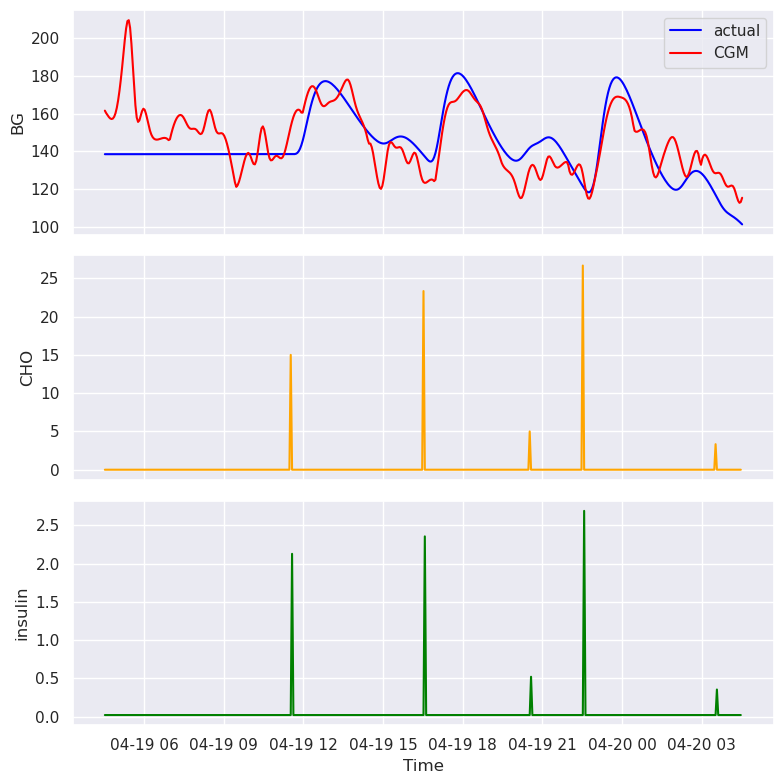

In [5]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))
sns.lineplot(x="Time", y="BG", color="blue", data=results, ax=ax[0], label="actual")
sns.lineplot(x="Time", y="CGM", color="red", data=results, ax=ax[0], label="CGM")
sns.lineplot(x="Time", y="CHO", color="orange", data=results, ax=ax[1])
sns.lineplot(x="Time", y="insulin", color="green", data=results, ax=ax[2])
plt.tight_layout()
plt.show()

# **Parameter Estimation Workflow**

## Load and preprocess data

In [6]:
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

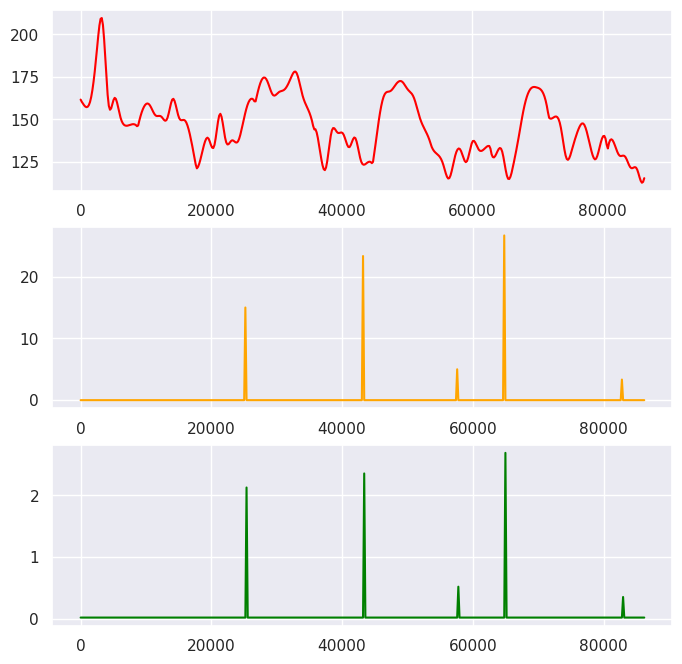

In [7]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [8]:
scen = [[data_t[i] / (60 * 60), 3 * data_CHO[i]] for i in np.where(data_CHO > data_CHO[0])[0]]
case_scenario = CustomScenario(start_time=datetime.now(), scenario=scen)

## Algorithm setup

In [9]:
# load parameters
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_min = adult_params.min()
p_max = adult_params.max()
p_range = np.stack([p_min, p_max], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return {
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    }

In [10]:
est_mean = orig_params.loc[orig_params.Name.str.contains("adult")].mean(numeric_only=True).loc[est_params]
est_std = orig_params.loc[orig_params.Name.str.contains("adult")].std(numeric_only=True).loc[est_params]

In [11]:
def objective(params, sensor, pump, scenario, controller):
    patient = T1DPatient.withParams(params)

    env = T1DSimEnv(patient, sensor, pump, scenario)

    s = SimObj(env, controller, timedelta(days=1), animate=False, path=RESULTS_PATH)
    results = sim(s)

    cgm_preds = results.BG.to_numpy()

    return cgm_preds

In [12]:
sensor = CGMSensor.withName("Dexcom", seed=GLOBAL_SEED)
pump = InsulinPump.withName("Insulet")
controller = BBController()

In [13]:
# evolutionary algorithm parameters
NGEN = 100
SIGMA = 5
LAMBDA = 20

# target function
def evaluate(p):
    try:
        pred_CGM = objective(construct_params(p), sensor, pump, case_scenario, controller)
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]

# evolutionary algorithm setup
creator.create("FitnessMin", base.Fitness, weights=[-1.0])
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# enable multiprocessing
pool = mp.Pool()
toolbox.register("map", pool.map)

# inital parameter guess
p_guess = est_mean.to_numpy()

# CMA-ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda i: i.fitness.values)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

Process ID: 12744
Simulation starts ...
Simulation Completed!


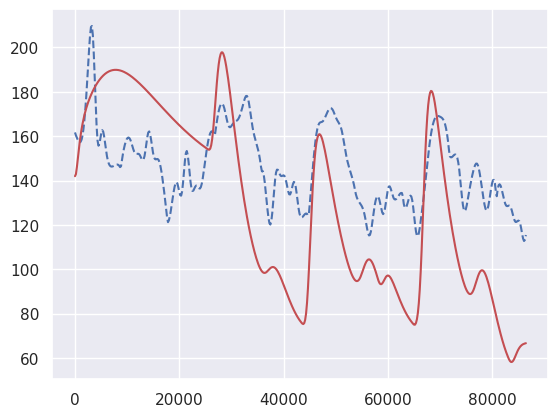

In [14]:
p = est_mean.to_numpy()
pred_CGM = objective(construct_params(p), sensor, pump, case_scenario, controller)
plt.plot(data_t, data_CGM, "b--")
plt.plot(data_t, pred_CGM, "r")
plt.show()

In [15]:
# train loop
def train(toolbox, ngen, stats, halloffame):
    loss_history = []
    for _ in range(ngen):
        # generate a new population
        population = toolbox.generate()

        # evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        # update the strategy with the evaluated individuals
        toolbox.update(population)

        record = stats.compile(population) if stats is not None else {}
        loss_history.append(record["min_loss"])

        clear_output(wait=True)
        plt.plot(loss_history, "r.-")
        plt.show()

    return loss_history

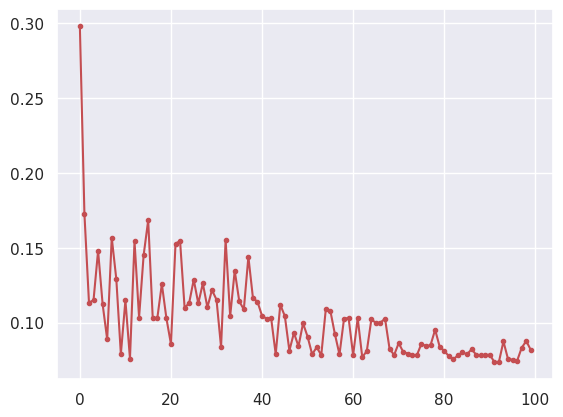

[0.29786975936256,
 0.17262456226733044,
 0.11344217893122331,
 0.1149843768788395,
 0.14798998406909908,
 0.11226825888774608,
 0.0888030209572638,
 0.1566865589161337,
 0.1291302539811733,
 0.07901877522471668,
 0.11491145303200168,
 0.07606352716101894,
 0.1543706866115585,
 0.10343620914245255,
 0.14498427116422444,
 0.16827976296510203,
 0.10300011130848874,
 0.10295830898873952,
 0.12581529054462554,
 0.1029626799584024,
 0.08568138287846196,
 0.15268803564105035,
 0.15448977835808553,
 0.10979017024003876,
 0.11322050131217407,
 0.1286660943055988,
 0.11285370126426617,
 0.1261896025118352,
 0.11021559757496727,
 0.12178335082212104,
 0.11536271482481684,
 0.0837029101671508,
 0.15529862619766638,
 0.10435265113412812,
 0.13470420933766228,
 0.11421204042864307,
 0.10884950530216067,
 0.14396735981912961,
 0.11648015745439867,
 0.11393874686027743,
 0.10456624378054524,
 0.10267580573843821,
 0.10288357907000818,
 0.07895866728981946,
 0.11196365178098372,
 0.10445510384540219,


In [16]:
train(toolbox, NGEN, stats, hof)

Process ID: 12744
Simulation starts ...
Simulation Completed!


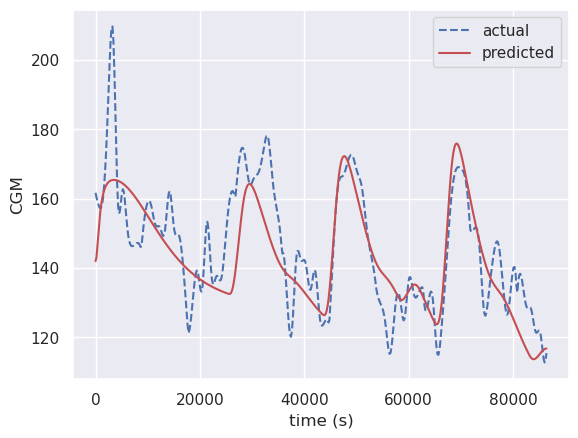

In [17]:
# plot results
pred_CGM = objective(construct_params(hof[0]), sensor, pump, case_scenario, controller)
plt.plot(data_t, data_CGM, "b--", label="actual")
plt.plot(data_t, pred_CGM, "r", label="predicted")
plt.ylabel("CGM")
plt.xlabel("time (s)")
plt.legend()
plt.show()

In [18]:
pred_CGM = objective(construct_params(hof[0]), sensor, pump, case_scenario, controller)

Process ID: 12744
Simulation starts ...
Simulation Completed!


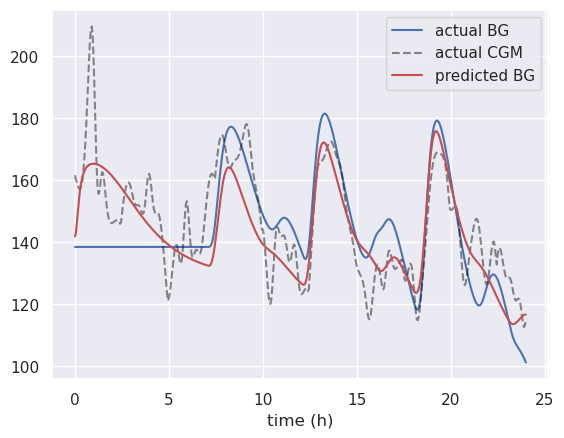

In [19]:
plt.plot(data_t / 3600, data_BG, "b", label="actual BG")
plt.plot(data_t / 3600, data_CGM, "k--", label="actual CGM", alpha=0.5)
plt.plot(data_t / 3600, pred_CGM, "r", label="predicted BG")
plt.xlabel("time (h)")
plt.legend()
plt.show()